# Overview of the Problem

#### **The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile.**
1. How do card issuers know we’ll pay back what we charge?
2. Credit default prediction allows lenders(prestamistas) to optimize lending decisions
3. Credit default prediction is central to managing risk in a consumer lending business.
4. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.
5. In this competition, you’ll apply your machine learning skills to predict credit default.

# About Data
1. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information.
2. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.
3. The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

    * D_* = Delinquency variables
    * S_* = Spend variables
    * P_* = Payment variables
    * B_* = Balance variables
    * R_* = Risk variables

    with the following features being categorical: ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    
**Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).
Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.**

# About the Metric
M is the mean of two measures of rank ordering.

$$ M = 0.5(G+D) $$
Where G is the Normalized Gini Coefficient, and D the Default Rate captured at 4%

The Default Rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics G and D, the negative labels are given a weight of 20 to adjust for downsampling.

python implementation: https://www.kaggle.com/code/inversion/amex-competition-metric-python


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
import gc
import seaborn as sns
from pathlib import Path

path_amex_csv = Path('/kaggle/input/amex-default-prediction/')
path_amex_parquet = Path('/kaggle/input/amex-data-integer-dtypes-parquet-format/')

In [3]:
%%time
df_labels_train = pd.read_csv(path_amex_csv / 'train_labels.csv', index_col='customer_ID')

CPU times: user 686 ms, sys: 223 ms, total: 909 ms
Wall time: 1.34 s


In [4]:
%%time
df_data_train_parquet = pd.read_parquet(path_amex_parquet / 'train.parquet')

CPU times: user 9.49 s, sys: 9.66 s, total: 19.2 s
Wall time: 19.8 s


In [5]:
print(df_data_train_parquet.shape)
print(df_labels_train.shape)
categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

(5531451, 190)
(458913, 1)


# 1. Check Samples and Date

In [6]:
df_custID_date = df_data_train_parquet[['customer_ID', 'S_2']]
print(df_custID_date.shape)
gc.collect()

(5531451, 2)


46

In [7]:
# Analyzing the dates
df_max_date = df_custID_date.groupby('customer_ID').max()
df_min_date = df_custID_date.groupby('customer_ID').min()
df_diff_date = (pd.to_datetime(df_max_date['S_2']) - pd.to_datetime(df_min_date['S_2'])).map(lambda x: x.days)
display(df_diff_date.sort_values().iloc[0:10])
display(df_diff_date.sort_values().iloc[-10:])
print('mounthly records for customers with 0 and 1 labels ', 395/30)
gc.collect()

customer_ID
3aa011de85a1a4ab4f0687190f181439a7f7bff8d08887972e9c72633cdd72e7    0
908c1f0eb1c27bb6ef7f261139b61bcb157fe3bb08f66c58b64aa3b9859e4899    0
e2030098efd217b4ca24bb5b31abf09788fbbdb6c45eaedd991d3df950d7efd1    0
ba7f2bee48893f4ad2f9b52967c8ab5b7f25c4119f095e8f3f9072200c8a3808    0
63fa1dae6ae716a7a5d1455b284681588b161cd35a03e73c6219bba5cd1c2fb5    0
37007a88976b00c3b58ec5dd4984e8f25858db945b277c80660fe60e7aa0aa18    0
722bc5f514bf3aed79a2f8f33fbeae1fc9316b458e30771f884bcd72036e0163    0
3b7149c497417ce353701aa7c5a58189b5b1e791e9eb398b7c8460c97098e93d    0
bd1b21a5da2f59814a24ac05f907b4130fa6a5223756c6ed217eb707851da654    0
bd1b37408014dc66559401efffa30318e0d9d886bf412127fb81741fca9f10ba    0
Name: S_2, dtype: int64

customer_ID
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f832420a84242b0aad2c    395
16f8cf9065d8cf81f3a7ee6b4b326cf505a3fae4c8e56bb3f7abfc9a2f509834    395
92cef0a74b98874a77902f6288f9b8ed8a5131634581d0f93518b42207a73f7f    395
25ada08859775be120ce91d373c241862c778191a22175d2bcedf4d903291652    395
0438c17fd238859f6660ece597d69fd197b3e1a9763f96571bfd169e0d58bdc6    395
b6f4356177f134dc89792ea75277a87977b311a1df195254acc05bbb152803e3    395
1d3f6960593d9f3f73d13aac534e0d21d59aa0b1ccabdabe94dbcff84a18d92e    395
af517228480a925e23663ee0c8b670236349ff386e1a8c8c4dbc90080aca04b3    395
4bed06698e81be59ed794b5838133c9d370af278badfb026d55d7c2a9ad84c68    395
a60b33131e236d9522a21b7af82afe0cefb9f049aa6e4fe006f7f071c5d73e80    395
Name: S_2, dtype: int64

mounthly records for customers with 0 and 1 labels  13.166666666666666


0

Text(0.5, 1.0, 'Numero of days for each customer')

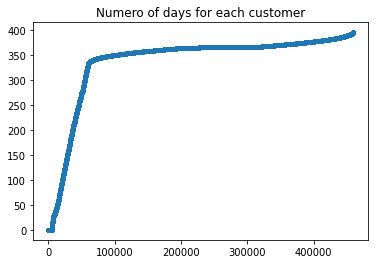

In [8]:
ax = df_diff_date.sort_values().reset_index()['S_2'].plot(style='.')
ax.set_title('Numero of days for each customer')

In [9]:
df_custID_date.set_index('customer_ID', inplace=True)
print(df_custID_date.loc['3aa011de85a1a4ab4f0687190f181439a7f7bff8d08887972e9c72633cdd72e7']) #1 day 
print()
print(df_custID_date.loc['2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f832420a84242b0aad2c']) #395 days
df_samples_by_id = df_custID_date.groupby(level=0).count()
df_samples_by_id.columns = ['Num_Dates']
display(df_samples_by_id.sort_values('Num_Dates').iloc[0:10,])
display(df_samples_by_id.sort_values('Num_Dates').iloc[-10:,])
gc.collect()

S_2    2018-03-31
Name: 3aa011de85a1a4ab4f0687190f181439a7f7bff8d08887972e9c72633cdd72e7, dtype: object

                                                           S_2
customer_ID                                                   
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-03-01
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-04-14
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-05-01
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-06-29
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-07-24
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-08-31
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-09-14
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-10-11
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-11-24
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2017-12-14
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2018-01-02
2f4def50b25fc4b40f47e3f2760e30a6e957c24a0414f83...  2018-02-16
2f4def50b25fc

,Num_Dates
customer_ID,
268ba31cb8ca378b7355e45ee2d476c8f245f5d7f7c5ac8d2220da790692354d,1
398b2284afa95bcb5e45b9d0a12b3b9489417c7e85e3d4201949126dea87dfb2,1
f6a5f41c78d34e3283f4a5f1ab5dd84195783af511fc3a2b450e459a1eca6371,1
914821e33ef409f4f2c3b1e82c21d69bf18d5c7f8a3bd470e8f32eade782440c,1
d7eac493c711f26e608cc619384fc0eb6df04859da94bb5bfde386b75eb4c14f,1
be7a4f53b7f695c08c1364ef8b981f0bbea32bdfa7cddcf7738a78096d8e3a05,1
353ba249166e0506a004fd474275f8c3d68b9670a786f07a61c58d866895a2e3,1
a1c70f57d0ae651ac7e0253523ec43998d3950201235d22554e79f2c2f24334d,1
270048c153b02328383135b66e6f0ec336087a0f367348d70d00057fd515c4e8,1


,Num_Dates
customer_ID,
5c6b5ae2c487197e8cbc2d7663dc84878bd09c7fdb9699c0492a3cd64f352cef,13
5c6b3fc73f9c3481648a9b9750c3785c3218a0c67fd630e710641ad402d13c9f,13
5c6aef8aac83c5114abd735449d6270d8c9c4db4af3fa56ef3226ce9cffee4ff,13
5c6aacbaefc8818b2d3604bad2cc449ac3b289b1f524f731d5e1228b675b900c,13
5c6a594f885690556b6f77946f996bc03b9ed62623f7499f06991df8af1b5b20,13
5c6a469918b7badb212b6f33feb344096202679a44473295c4cb54a295801d35,13
5c6a423106d22db96000f5c02dde5de937b18ea1d653ccdf19bba6777a54aafb,13
5c6a3483b4bb775550043ae126163ec1d9216dececfcaf20502e1a4599c333b8,13
5c6bded8a6ba8c94ad66e6210d58d5008813c5192b740e1ef0d0476151d02ca5,13


0

In [10]:
df_customers_by_sample  = df_samples_by_id.reset_index().groupby('Num_Dates').count()
df_customers_by_sample

,customer_ID
Num_Dates,
1,5120
2,6098
3,5778
4,4673
5,4671
6,5515
7,5198
8,6110
9,6411


In [11]:
df_all_dates_by_cust_ID = pd.DataFrame(df_custID_date.groupby(level=0).apply(lambda x:x.values))
df_all_dates_by_cust_ID.columns = ['list_dates']
df_all_dates_by_cust_ID

,list_dates
customer_ID,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,"[[2017-03-09], [2017-04-07], [2017-05-28], [20..."
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,"[[2017-03-01], [2017-04-16], [2017-05-07], [20..."
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,"[[2017-03-11], [2017-04-11], [2017-05-12], [20..."
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,"[[2017-03-31], [2017-04-21], [2017-05-29], [20..."
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,"[[2017-03-30], [2017-04-22], [2017-05-30], [20..."
...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,"[[2017-03-20], [2017-04-25], [2017-05-03], [20..."
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,"[[2017-03-22], [2017-04-06], [2017-05-22], [20..."
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,"[[2017-03-16], [2017-04-23], [2017-05-21], [20..."


### **Range of dates for each group of customers**

* Customers with 1 sample were register in the '2018-03-x' where x is some day into the mounth

* Customers with 2 samples were register in the [2018-01-x, 2018-03-x] where x is some day into the mounth

* Customers with 3 samples were register in the [2018-01-x, 2018-03-x] where x is some day into the mounth

* Customers with 4 samples were register in the ['2017-12-15', '2018-01-15', '2018-02-05','2018-03-15'] where x is some day into the mounth

* Customers with 5 samples were register in the ['2017-11-07', '2017-12-08', '2018-01-08', '2018-02-05', '2018-03-08']

* Customers with 6 samples were register in the ['2017-10-28', '2017-11-21', '2017-12-26', '2018-01-02', '2018-02-02', '2018-03-31']

* Customers with 7 samples were register in the ['2017-09-13', '2017-10-26', '2017-11-25', '2017-12-26', '2018-01-19', '2018-02-15', '2018-03-26']

* Customers with 8 samples were register in the ['2017-08-31','2017-09-16','2017-10-02','2017-11-14','2017-12-14','2018-01-18','2018-02-15','2018-03-17']
* Customers with 9 samples were register in the ['2017-07-31','2017-08-02','2017-09-20','2017-10-07','2017-11-08','2017-12-28','2018-01-10','2018-02-14','2018-03-28']
* Customers with 10 samples were register in the ['2017-06-09','2017-07-29','2017-08-30','2017-09-29','2017-10-20','2017-11-02','2017-12-04','2018-01-24','2018-02-02','2018-03-12']
* Customers with 11 samples were register in the ['2017-05-12', '2017-06-12','2017-07-13','2017-08-26','2017-09-20','2017-10-08','2017-11-09','2017-12-16','2018-01-13','2018-02-10','2018-03-06']
* Customers with 12 samples were register in the ['2017-04-12', '2017-05-12', '2017-06-12','2017-07-13','2017-08-26','2017-09-20','2017-10-08','2017-11-09','2017-12-16','2018-01-13','2018-02-10','2018-03-06']
* Customers with 13 samples were register in the ['2017-03-12', '2017-04-12', '2017-05-12', '2017-06-12','2017-07-13','2017-08-26','2017-09-20','2017-10-08','2017-11-09','2017-12-16','2018-01-13','2018-02-10','2018-03-06']

In [12]:
## Number and percentage of samples for each label 0 and 1
df_num_samples_target = df_samples_by_id.join(df_labels_train, how='inner')
display(df_num_samples_target.head())
# df_num_samples_target.groupby('S_2').apply(lambda x:x.groupby('target').count())
df_samples_labels_distrib = pd.concat([df_num_samples_target.groupby('Num_Dates').apply(lambda x:x['target'].shape[0]-x['target'].sum()), 
         df_num_samples_target.groupby('Num_Dates').apply(lambda x:x['target'].sum())], axis=1)

df_samples_labels_distrib = pd.concat([df_samples_labels_distrib, 
                                       pd.DataFrame(df_samples_labels_distrib.values/df_samples_labels_distrib.sum(axis=1).values.reshape(-1,1), 
                                                    index=np.arange(13)+1)
                                      ],
                                        axis=1)
df_samples_labels_distrib.columns = ['num_0', 'num_1', '%0', '%1']
display(df_samples_labels_distrib)
gc.collect()


,Num_Dates,target
customer_ID,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,13,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,13,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,13,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,13,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,13,0


,num_0,num_1,%0,%1
1,3401,1719,0.664258,0.335742
2,4156,1942,0.681535,0.318465
3,3706,2072,0.641398,0.358602
4,2728,1945,0.583779,0.416221
5,2837,1834,0.607365,0.392635
6,3377,2138,0.612330,0.387670
7,3023,2175,0.581570,0.418430
8,3377,2733,0.552700,0.447300
9,3525,2886,0.549836,0.450164
10,3614,3107,0.537718,0.462282


23

#### **Note**

* The data was collected from 2017-03-x to 2018-03-x in
* There are customers with 1 sample (collected in the 2018-13) and customers with 13 samples (collected from 2017-03-x to 2018-03-x)

# 2. Check Features

In [13]:
import matplotlib.pyplot as plt
color = sns.color_palette()

In [14]:
def get_features(all_features):
    dict_feat = {'P':[], 'S':[], 'D':[], 'B':[], 'R':[]}
    for feat in all_features:
        name, _ = feat.split('_')
        if name in dict_feat:
            dict_feat[name].append(feat)
    return dict_feat

all_features = df_data_train_parquet.columns
dict_features = get_features(list(all_features))
print('P-payment', len(dict_features['P']))
print('S-spend', len(dict_features['S']))
print('D-delinquency', len(dict_features['D']))
print('B-balance', len(dict_features['B']))
print('R-risk', len(dict_features['R']))

P-payment 3
S-spend 22
D-delinquency 96
B-balance 40
R-risk 28


In [15]:
df_data_S_features = df_data_train_parquet[['customer_ID']+dict_features['S']]
df_data_S_features.set_index('customer_ID', inplace=True)

df_data_S_features = df_samples_by_id.join(df_data_S_features, how='inner') #join the num_samples by id
df_data_S_features = df_labels_train.join(df_data_S_features, how='inner') #join the labels
print(df_data_S_features.shape)
display(df_data_S_features.iloc[0:3])
gc.collect()
gc.collect()

(5531451, 24)


,target,Num_Dates,S_2,S_3,S_5,S_6,S_7,S_8,S_9,S_11,...,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,13,2017-03-09,0.124035,0.023381,0,0.161345,2896,0.065728,15,...,0.008033,0,0.002537,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.676922
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,13,2017-04-07,0.126750,0.030599,0,0.140951,2896,0.093935,15,...,0.000760,0,0.008427,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.822281
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,13,2017-05-28,0.123977,0.048367,0,0.112229,3166,0.084757,15,...,0.004056,0,0.007327,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.853498


0

In [16]:
## Select the customers with 13 samples to make the analysis
data = df_data_S_features[df_data_S_features['Num_Dates'] == 13]
data.shape

(5018442, 24)

In [17]:
# check the number of samples: number_customers*number_samples(13)
if df_customers_by_sample.loc[13].values[0]*13 == data.shape[0]:
    print(True)

print("The group of customers with 13 samples are:",df_customers_by_sample.loc[13].values[0], ' with 13 samples is a total:', 
      df_customers_by_sample.loc[13].values[0]*13,'\n', 'which represent ',(df_customers_by_sample.loc[13].values[0]*13)/5531451, 
      '% of the total of samples in the database, that is 5531451')    

True
The group of customers with 13 samples are: 386034  with 13 samples is a total: 5018442 
 which represent  0.907255980392848 % of the total of samples in the database, that is 5531451


### Features Analysis

In [70]:
def boxhist(column, df, figsize=(10,5)):
    variable = df[column].values 
    f, (ax_box, ax_hist) = plt.subplots(2, figsize=figsize, sharex=True, gridspec_kw= {"height_ratios": (1.0, 2)})
    mean=np.mean(variable)
    median=np.median(variable)
    
    sns.boxplot(variable, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.set_title(column)
    
    sns.distplot(variable, ax=ax_hist)
    ax_hist.axvline(mean, color='r', linestyle='--')
    ax_hist.axvline(median, color='g', linestyle='-')
    
    plt.title(column, fontsize=10, loc="center")
    plt.legend({'Mean':mean,'Median':median})
    ax_box.set(xlabel='')
    plt.show()
    
def type_and_nulls(df):
    df_type = pd.concat([pd.DataFrame(df.dtypes), df.isnull().sum().to_frame().rename(columns={0:'nulls'})], axis=1)
    display(df_type)
    display(df.dtypes.value_counts())
    not_nulls = list((df_type[df_type['nulls']==0]).index)
    print('Not null features: ', not_nulls)
    return not_nulls    

In [19]:
not_null_features = type_and_nulls(data)
gc.collect()

,0,nulls
target,int64,0
Num_Dates,int64,0
S_2,object,0
S_3,float32,954711
S_5,float32,0
S_6,int8,0
S_7,float32,954711
S_8,int16,0
S_9,float32,2642023
S_11,int8,0


float32    14
int8        5
int64       2
int16       2
object      1
dtype: int64

Not null features:  ['target', 'Num_Dates', 'S_2', 'S_5', 'S_6', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20']


23

In [21]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [23]:
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

In [40]:
data[not_null_features][data['target']==1].hist?

Docstring: Alias for `%history`.
File:      /opt/conda/lib/python3.7/site-packages/IPython/core/magic.py


array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'Num_Dates'}>,
        <AxesSubplot:title={'center':'S_5'}>,
        <AxesSubplot:title={'center':'S_6'}>],
       [<AxesSubplot:title={'center':'S_8'}>,
        <AxesSubplot:title={'center':'S_11'}>,
        <AxesSubplot:title={'center':'S_12'}>,
        <AxesSubplot:title={'center':'S_13'}>],
       [<AxesSubplot:title={'center':'S_15'}>,
        <AxesSubplot:title={'center':'S_16'}>,
        <AxesSubplot:title={'center':'S_17'}>,
        <AxesSubplot:title={'center':'S_18'}>],
       [<AxesSubplot:title={'center':'S_19'}>,
        <AxesSubplot:title={'center':'S_20'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

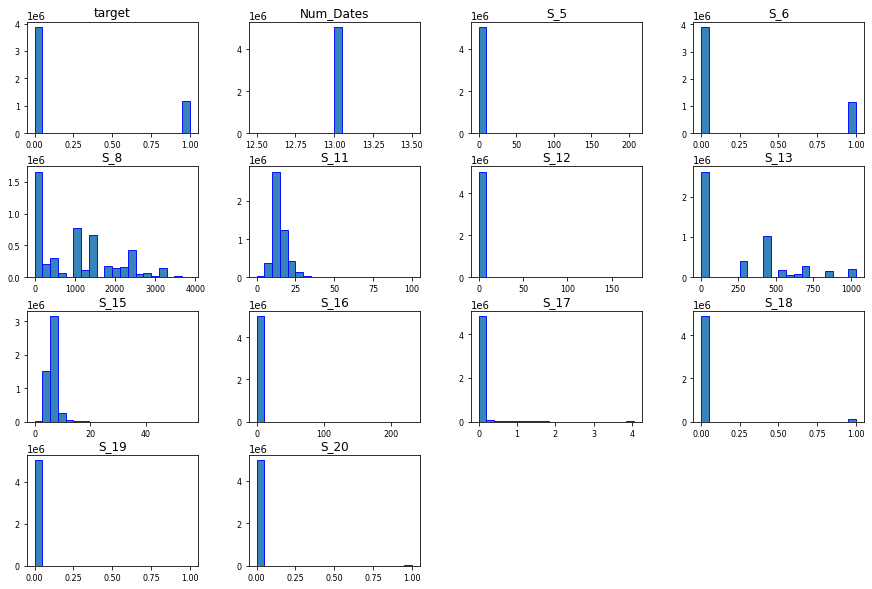

In [45]:
## features distribution
data[not_null_features].hist(figsize=(15,10), bins=20, ec="b", xlabelsize=8, ylabelsize=8, alpha=0.9, grid=False)
# palette, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
# column = 'S_5'
# row, col = (0, 1)
# fig, ax = plt.subplots(2,2, figsize=(10,9))
# fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
# plot_df = data[[column, 'target']]
# sns.kdeplot(x=column, hue='target', palette=palette[::-1], hue_order=[1,0], 
#                 label=['Default','Paid'], data=plot_df, 
#                 fill=True, linewidth=2, legend=False, ax=ax[row,col])
# ax[row,col].tick_params(left=False,bottom=False)
# ax[row,col].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))

In [111]:
def plot_transformations(data, column, min_value, limit_value=1, with_log=True, with_log_slope=True, slope=1e-4):
    
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    print('data type:', data[[column]].dtypes.values)
    print('total samples:', data[[column]].shape[0], ',  num of extreme values:', np.sum(data[[column]]>limit_value).values)
    print('With limit value of limit value of ',limit_value, ' that represent ', 
          np.sum(data[[column]]>limit_value).values[0]/data[[column]].shape[0], '% the data')
    display(data[[column]][data[column]<=limit_value].describe().T)
    data[column][data[column]<=limit_value].hist(bins=20, ec="b", alpha=0.9, grid=False, ax=ax[0])
    ax[0].set_title('With limit value of '+str(limit_value))
    
    if min_value>0:
        print('With log transformation')
        display(np.log(data[[column]]).describe().T)
        np.log(data[[column]]).hist(bins=20, ec="b", alpha=0.9, grid=False, ax=ax[1])
        ax[1].set_title('With log transformation')
    
    if with_log_slope:
        print('With log transformation and ', str(slope),' as a slope value')
        display(np.log(data[[column]]+1e-4).describe().T)
        np.log(data[[column]]+1e-4).hist(bins=20, ec="b", alpha=0.9, grid=False, ax=ax[2])
        ax[2].set_title('With log transformation and '+ str(slope)+' as a slope value')
        
        
def plot_discrete_data(data, column):        
    data[[column]].plot(style='.')
    data[[column]].sort_values(column).plot(style='.')

    tmp = data[['target', column]][data[column]==0]
    print('0s in the same position than the target' ,np.sum((tmp['target']+tmp[column]) == 0))
    print('correlation with \n' ,data[['target', column]].corr())
    print('value counts:\n', data[column].value_counts())        

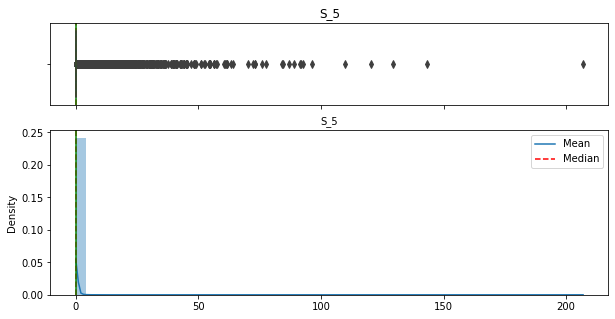

,count,mean,std,min,25%,50%,75%,max
S_5,5018442.0,0.088883,0.414946,8.168135e-09,0.00557,0.012985,0.071706,206.875275


In [82]:
column = 'S_5'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)

data type: [dtype('float32')]
total samples: 5018442 ,  num of extreme values: [5]
With limit value of limit value of  100  that represent  9.963251543008766e-07 % the data


,count,mean,std,min,25%,50%,75%,max
S_5,5018437.0,0.088742,0.388529,8.168135e-09,0.00557,0.012984,0.071706,96.298279


With log transformation


,count,mean,std,min,25%,50%,75%,max
S_5,5018442.0,-4.007073,1.815159,-18.623026,-5.19033,-4.343997,-2.635177,5.332116


With log transformation and  0.0001  as a slope value


,count,mean,std,min,25%,50%,75%,max
S_5,5018442.0,-3.981372,1.768931,-9.210259,-5.172537,-4.336324,-2.633783,5.332117


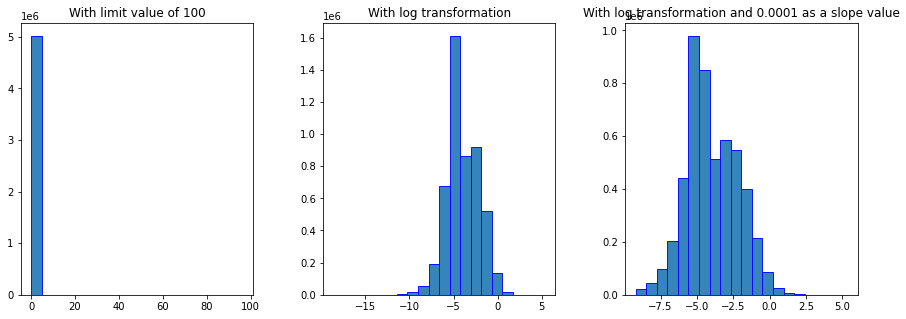

In [106]:
plot_transformations(data, column, min_value, limit_value=100, with_log_slope=True, slope=1e-4)

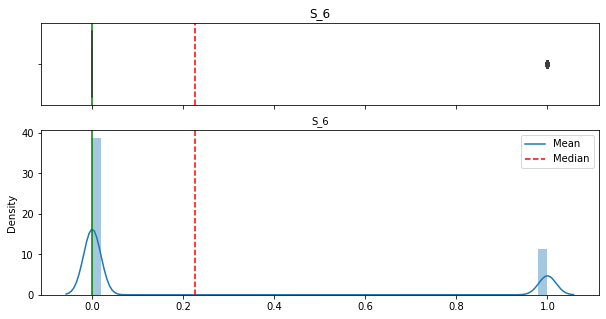

,count,mean,std,min,25%,50%,75%,max
S_6,5018442.0,0.224834,0.417473,0.0,0.0,0.0,0.0,1.0


In [107]:
column = 'S_6'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)

0s in the same position than the target 2878575
correlation with 
           target       S_6
target  1.000000 -0.124274
S_6    -0.124274  1.000000
0    3890125
1    1128317
Name: S_6, dtype: int64


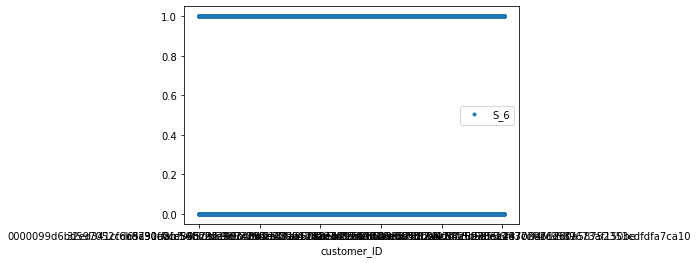

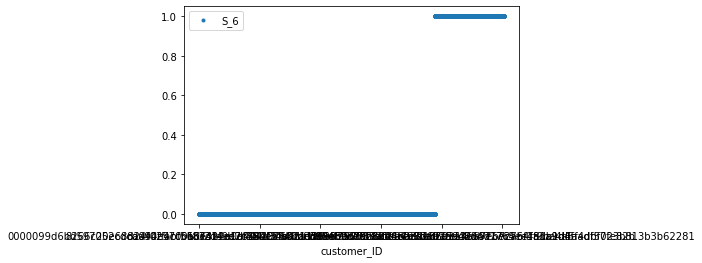

In [110]:
plot_discrete_data(data, column)

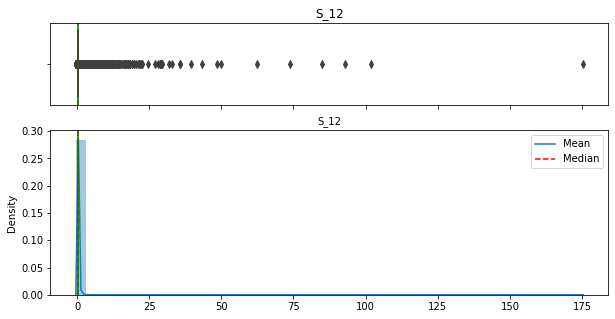

,count,mean,std,min,25%,50%,75%,max
S_12,5018442.0,0.239792,0.243982,-0.403528,0.186924,0.190863,0.210384,175.331421


152871

In [112]:
column = 'S_12'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)
gc.collect()

data type: [dtype('float32')]
total samples: 5018442 ,  num of extreme values: [6]
With limit value of limit value of  50  that represent  1.195590185161052e-06 % the data


,count,mean,std,min,25%,50%,75%,max
S_12,5018436.0,0.239674,0.215357,-0.403528,0.186924,0.190863,0.210384,49.897839


With log transformation and  0.403628  as a slope value


,count,mean,std,min,25%,50%,75%,max
S_12,4976287.0,-1.532293,0.425423,-14.377909,-1.675991,-1.655327,-1.552103,5.166679


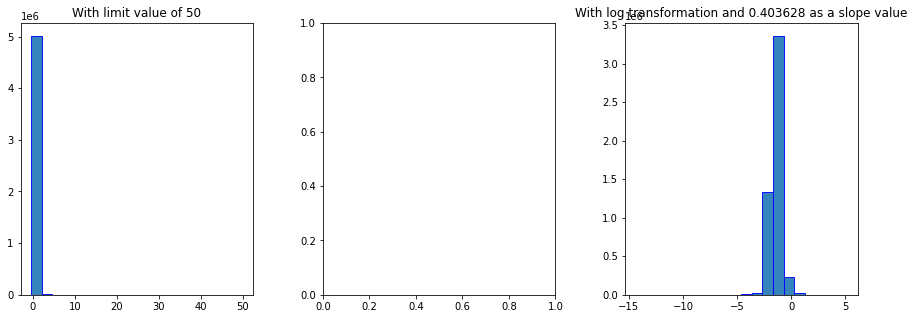

In [115]:
plot_transformations(data, column, min_value, limit_value=50, with_log_slope=True, slope=0.403528+1e-4)

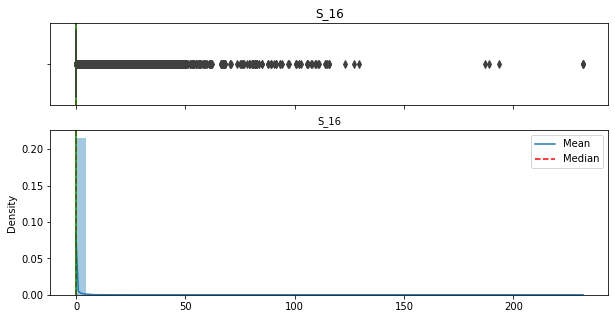

,count,mean,std,min,25%,50%,75%,max
S_16,5018442.0,0.044304,0.74126,5.083304e-09,0.002547,0.00509,0.007636,231.758942


56495

In [116]:
column = 'S_16'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)
gc.collect()

data type: [dtype('float32')]
total samples: 5018442 ,  num of extreme values: [134]
With limit value of limit value of  50  that represent  2.6701514135263494e-05 % the data


,count,mean,std,min,25%,50%,75%,max
S_16,5018308.0,0.042075,0.576353,5.083304e-09,0.002547,0.00509,0.007636,49.673271


With log transformation


,count,mean,std,min,25%,50%,75%,max
S_16,5018442.0,-5.50738,1.241268,-19.097305,-5.973001,-5.280521,-4.874908,5.445698


With log transformation and  0.0001  as a slope value


,count,mean,std,min,25%,50%,75%,max
S_16,5018442.0,-5.452286,1.148382,-9.21029,-5.934484,-5.261065,-4.861897,5.445698


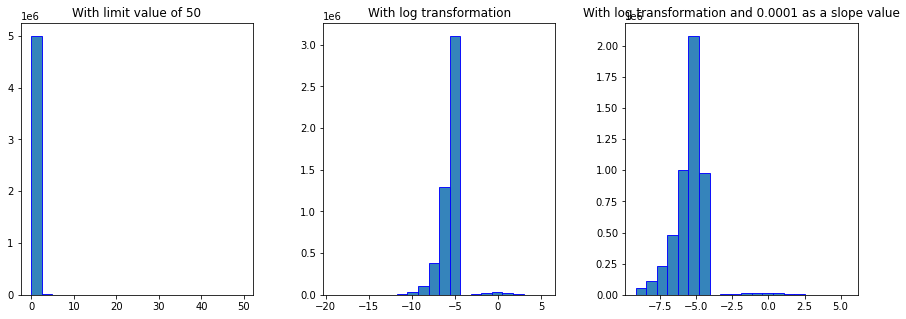

In [117]:
plot_transformations(data, column, min_value, limit_value=50, with_log_slope=True, slope=1e-4)

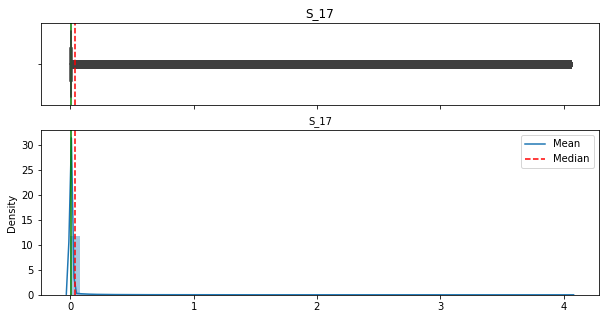

,count,mean,std,min,25%,50%,75%,max
S_17,5018442.0,0.039553,0.238646,1.019806e-09,0.002692,0.005378,0.008065,4.04907


21079

In [118]:
column = 'S_17'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)
gc.collect()

data type: [dtype('float32')]
total samples: 5018442 ,  num of extreme values: [0]
With limit value of limit value of  50  that represent  0.0 % the data


,count,mean,std,min,25%,50%,75%,max
S_17,5018442.0,0.039553,0.238646,1.019806e-09,0.002692,0.005378,0.008065,4.04907


With log transformation


,count,mean,std,min,25%,50%,75%,max
S_17,5018442.0,-5.322455,1.453737,-20.703653,-5.917655,-5.225419,-4.820263,1.398487


With log transformation and  0.0001  as a slope value


,count,mean,std,min,25%,50%,75%,max
S_17,5018442.0,-5.270257,1.372791,-9.21033,-5.881175,-5.206996,-4.80794,1.398512


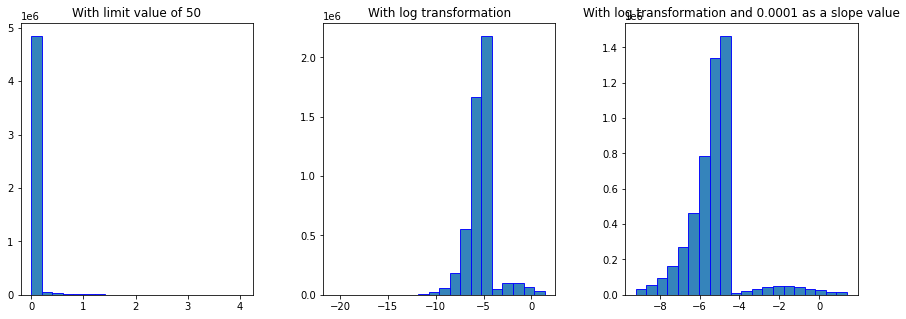

In [119]:
plot_transformations(data, column, min_value, limit_value=50, with_log_slope=True, slope=1e-4)

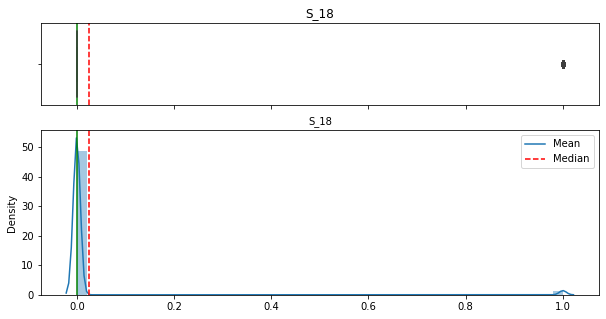

,count,mean,std,min,25%,50%,75%,max
S_18,5018442.0,0.025948,0.158982,0.0,0.0,0.0,0.0,1.0


20710

In [120]:
column = 'S_18'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)
gc.collect()

0s in the same position than the target 3753291
correlation with 
           target      S_18
target  1.000000 -0.005642
S_18   -0.005642  1.000000
value counts:
 0    4888221
1     130221
Name: S_18, dtype: int64


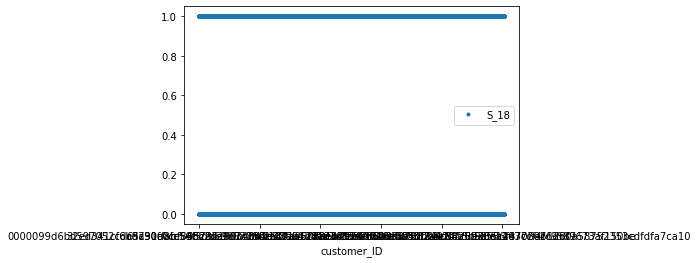

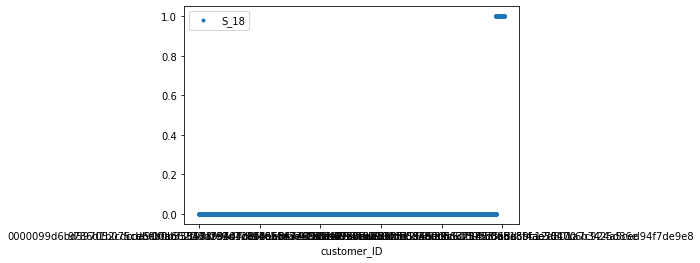

In [122]:
plot_discrete_data(data, column)

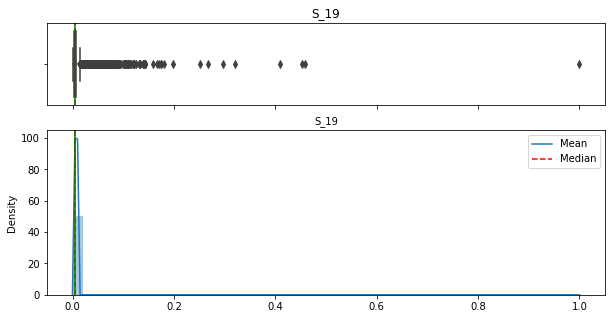

,count,mean,std,min,25%,50%,75%,max
S_19,5018442.0,0.005019,0.003045,3.156390e-09,0.002502,0.005004,0.007508,1.0


22527

In [123]:
column = 'S_19'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)
gc.collect()

data type: [dtype('float32')]
total samples: 5018442 ,  num of extreme values: [8]
With limit value of limit value of  0.2  that represent  1.5941202468814027e-06 % the data


,count,mean,std,min,25%,50%,75%,max
S_19,5018434.0,0.005018,0.002983,3.156390e-09,0.002502,0.005004,0.007508,0.198737


With log transformation


,count,mean,std,min,25%,50%,75%,max
S_19,5018442.0,-5.603765,1.001829,-19.573837,-5.990694,-5.297486,-4.891815,0.0


With log transformation and  0.0001  as a slope value


,count,mean,std,min,25%,50%,75%,max
S_19,5018442.0,-5.547627,0.887714,-9.210309,-5.951502,-5.2777,-4.878583,0.0001


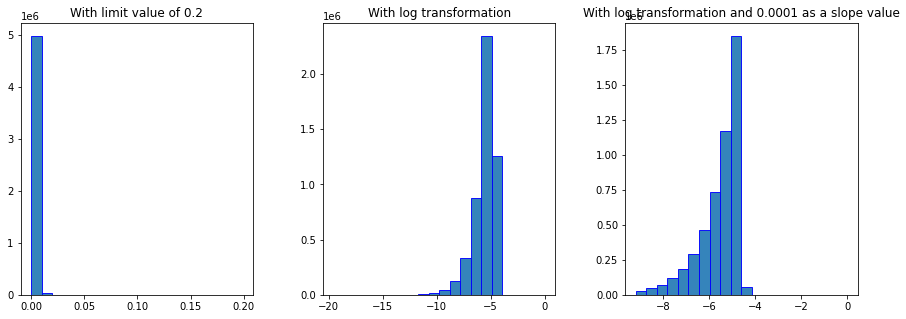

In [125]:
plot_transformations(data, column, min_value, limit_value=0.2, with_log_slope=True, slope=1e-4)

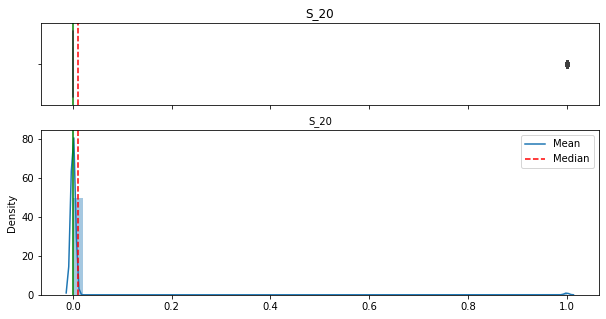

,count,mean,std,min,25%,50%,75%,max
S_20,5018442.0,0.010396,0.10143,0.0,0.0,0.0,0.0,1.0


32204

In [126]:
column = 'S_20'
boxhist(column, data)
min_value = np.min(data[[column]].values)
display(data[[column]].describe().T)
gc.collect()

0s in the same position than the target 3841611
correlation with 
           target      S_20
target  1.000000  0.123199
S_20    0.123199  1.000000
value counts:
 0    4966270
1      52172
Name: S_20, dtype: int64


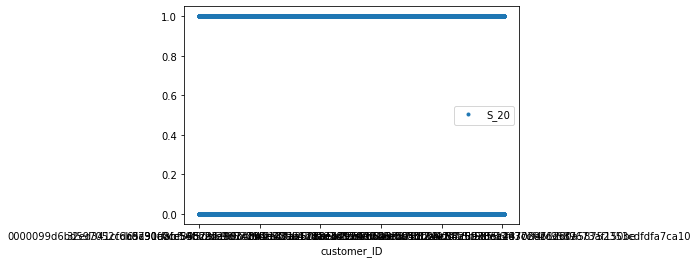

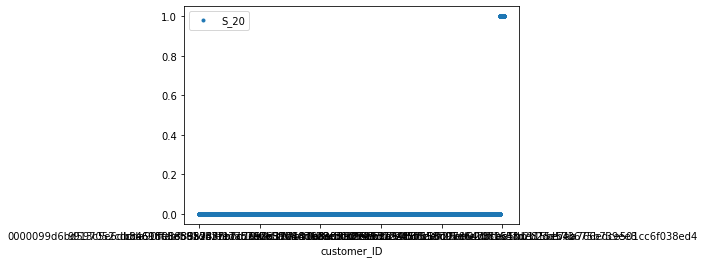

In [127]:
plot_discrete_data(data, column)